In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import capytaine as cpy

import wecopttool as wot

In [26]:
# f1 = 0.05
# nfreq = 50
# freq = wot.frequency(f1, nfreq)[1:]

wb = wot.geom.WaveBot()  # use standard dimensions
mesh_size_factor = 0.5 # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="HEAVE")

# data = wot.run_bem(fb, freq)
# wot.write_netcdf('bem.nc', data)

The rotation dof Roll has been initialized around the origin of the domain (0, 0, 0).
The rotation dof Pitch has been initialized around the origin of the domain (0, 0, 0).
The rotation dof Yaw has been initialized around the origin of the domain (0, 0, 0).


In [ ]:
unstructured = False  # controller
electrical = True  # power

In [2]:
file = "./bem.nc"
data = wot.read_netcdf(file)
f1 = 0.05
nfreq = 50

In [3]:
data

<xarray.Dataset>
Dimensions:              (omega: 50, influenced_dof: 1, wave_direction: 1,
                          radiating_dof: 1)
Coordinates:
  * omega                (omega) float64 0.3142 0.6283 0.9425 ... 15.39 15.71
  * influenced_dof       (influenced_dof) object 'HEAVE'
  * wave_direction       (wave_direction) float64 0.0
    g                    float64 9.81
    rho                  float64 1.025e+03
    body_name            <U16 'WaveBot_immersed'
    water_depth          float64 inf
  * radiating_dof        (radiating_dof) object 'HEAVE'
Data variables:
    added_mass           (omega, radiating_dof, influenced_dof) float64 1.459...
    radiation_damping    (omega, radiating_dof, influenced_dof) float64 9.442...
    diffraction_force    (omega, wave_direction, influenced_dof) complex128 (...
    Froude_Krylov_force  (omega, wave_direction, influenced_dof) complex128 (...
Attributes:
    start_of_computation:                     2022-07-26T10:30:38.199600
    green_function:                           Delhommeau
    tabulation_nr:                            328
    tabulation_nz:                            46
    tabulation_nb_integration_points:         251
    finite_depth_prony_decomposition_method:  fortran
    engine:                                   BasicMatrixEngine
    matrix_cache_size:                        1
    linear_solver:                            direct
    creation_of_dataset:                      2022-07-26T10:30:52.872928
    incoming_waves_convention:                nemoh
    capytaine_version:                        1.4

In [30]:
# fb.center_of_mass = fb.center_of_buoyancy
# fb.keep_immersed_part().compute_hydrostatic_stiffness()[2:5, 2:5]
# fb.compute_rigid_body_inertia()

RectangularParallelepiped(mesh=rectangular_parallelepiped_10_mesh, dofs={}, name=rectangular_parallelepiped_10)

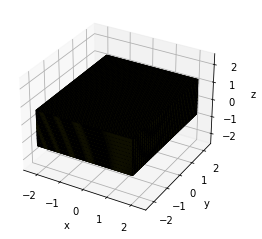

: 

In [38]:
lx, ly, lz = 4.0, 5.0, 2.0
fbr = cpy.RectangularParallelepiped((lx, ly, lz),(100,100,10), center=(0,0,0))
fbr.show_matplotlib()

In [35]:
fbr.add_all_rigid_body_dofs()
fbr

RectangularParallelepiped(mesh=rectangular_parallelepiped_13_mesh, dofs={Surge, Sway, Heave, Roll, Pitch, Yaw}, name=rectangular_parallelepiped_13)

In [ ]:
amplitude = 0.0625 
idx = 6  # 0.3 Hz
freq = idx*f1
waves = wot.waves.regular_wave(f1, nfreq, freq, amplitude)

In [ ]:
ndof_pto = 1
pto_names = ["PTO_Heave"]
kinematics_mat = np.eye(ndof_pto)

# controller
if unstructured:
    ncomponents_pto = 2*nfreq + 1
    controller = wot.pto.controller_unstructured
else:
    ncomponents_pto = 2
    controller = wot.pto.controller_pi

# PTO impedance - frequency dependent
omega = data.omega.values
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0.0
drivetrain_inertia = 2.0
drivetrain_friction = 1.0
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                        drivetrain_friction + 
                        1/(1j*omega)*drivetrain_stiffness) 

winding_impedance = winding_resistance + 1j*omega*winding_inductance


pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                          [pto_impedance_21, pto_impedance_22]])

# PTO
pto = wot.pto.PTO(ndof_pto, kinematics_mat, controller, pto_impedance, None, pto_names)

In [ ]:
data = wot.add_zerofreq_to_xr(data)
wec = wot.WEC.from_bem(data, f_add={'PTO': pto.force_on_wec})

In [ ]:
scale_x_wec = 1.0
scale_x_opt = 0.01 if ((not unstructured) and electrical) else 1.0
scale_obj = 1.0
if electrical:
    obj_fun = pto.average_power
else:
    obj_fun = pto.mechanical_average_power
res = wec.solve(waves, obj_fun, pto.ndof*ncomponents_pto,
                scale_x_wec=scale_x_wec, scale_x_opt=scale_x_opt, scale_obj=scale_obj)

In [ ]:
exc_coeff = data['Froude_Krylov_force'] + data['diffraction_force']
Fe = wot.wave_excitation(exc_coeff, waves)
w = data.coords['omega'].values[1:]
m = data['mass'].values
A = data['added_mass'].values[0, 0, 1:]
B = data['radiation_damping'].values[0, 0, 1:]
K = data['hydrostatic_stiffness'].values
Zi = ((1j*w)*(m + A)
        + B
        + (1/(1j*w)) * data['hydrostatic_stiffness'].values
        + 36.667232716402985)
Fe = np.reshape(Fe, -1)[1:]
Zi = np.reshape(Zi, -1)

if electrical:
    Z_11 = pto_impedance[0, 0, :]
    Z_12 = pto_impedance[0, 1, :]
    Z_21 = pto_impedance[1, 0, :]
    Z_22 = pto_impedance[1, 1, :]

    V_th = Z_21 / (Z_11 - Zi) * Fe
    Z_th = Z_22 - (Z_12*Z_21) / (Z_11 - Zi)

    cc_current_fd = V_th / (2*Z_th.real)
    cc_voltage_fd = -1.0 * Z_th.conj() * cc_current_fd
    cc_voltage_td = wec.fd_to_td(np.concatenate([[0.0], cc_voltage_fd]))
    cc_current_td = wec.fd_to_td(np.concatenate([[0.0], cc_current_fd]))
    cc_power_td = cc_voltage_td * cc_current_td
    power_theoretical = -np.sum(cc_power_td) * wec.dt/wec.tf
else:
    Fe = Fe[idx-1]
    Zi = Zi[idx-1]
    power_theoretical = (np.abs(Fe)**2 / (8 * Zi.real))

power = -res.fun
power, power_theoretical

In [ ]:
if not unstructured:
    xopt = res.x[-pto.ndof*ncomponents_pto:]
    if electrical:
        optimal_gains_expected = "TODO, "
    else:
        omega_wave = waves.omega[idx].data.item()
        m = data['mass'] 
        w = data['omega']
        A = data['added_mass']
        B = data['radiation_damping']
        K = data['hydrostatic_stiffness']
        Bf = 36.667232716402985
        Zi = 1j*w*(A+m) + B+Bf + 1/(1j*w)*K
        Zic = Zi[idx].conj().data.item()
        optimal_gains_expected = -1*Zic.real + 1j * omega_wave * Zic.imag
    optimal_gains = xopt[0] + 1j*xopt[1]
    print(optimal_gains_expected, optimal_gains)

In [ ]:
x_wec, x_opt = wec.decompose_state(res.x)
pos = wec.vec_to_dofmat(x_wec)
vel = wec.derivative_mat @ pos 
acc = wec.derivative_mat @ vel

pos_fd = wot.real_to_complex(pos)
vel_fd = wot.real_to_complex(vel)
acc_fd = wot.real_to_complex(acc)

pos_td = wec.time_mat @ pos
vel_td = wec.time_mat @ vel
acc_td = wec.time_mat @ acc

In [ ]:
plt.figure()
plt.plot(wec.frequency, np.log10(np.abs(pos_fd)), 'o')
plt.plot(wec.frequency, np.log10(np.abs(vel_fd)), 'o')
plt.plot(wec.frequency, np.log10(np.abs(acc_fd)), 'o')

# plt.plot(wec.frequency, np.abs(pos_fd), 'o')
# plt.plot(wec.frequency, np.abs(vel_fd), 'o')
# plt.plot(wec.frequency, np.abs(acc_fd), 'o')

In [ ]:
plt.figure()
plt.plot(wec.time, pos_td, '.-')
plt.plot(wec.time, vel_td, '.-')
plt.plot(wec.time, acc_td, '.-')